In [1]:
import pyaudio
import numpy as np
import webrtcvad
import collections
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models
import turtle

# Параметры записи аудио
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
FRAME_DURATION_MS = 30  # Длительность фрейма в миллисекундах
PADDING_DURATION_MS = 300  # Длительность дополнительной оконной рамки в миллисекундах
FRAME_SIZE = int(RATE * FRAME_DURATION_MS / 1000)  # Размер фрейма в сэмплах

commands = ['down', 'go', 'left', 'right', 'stop', 'up']
model = models.load_model('model.h5')

In [2]:
def plot_waveform(waveform):
    plt.figure(figsize=(10, 4))
    plt.plot(waveform)
    plt.title('Audio Waveform')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

In [3]:
def preprocess_audiobuffer(waveform):
    waveform = waveform / 32768
    waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)
    spectrogram = get_spectrogram(waveform)
    spectrogram=tf.expand_dims(spectrogram, 0)
    return spectrogram

In [4]:
def get_spectrogram(waveform):
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [input_len] - tf.shape(waveform),
        dtype=tf.float32)
    waveform = tf.cast(waveform, dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [5]:
def record_audio():
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=FRAME_SIZE)
    
    print("Listening...")

    try:
        while True:
            data = stream.read(FRAME_SIZE)
            yield np.frombuffer(data, dtype=np.int16)
    except KeyboardInterrupt:
        pass
    
    print("Recording stopped.")

    stream.stop_stream()
    stream.close()
    p.terminate()

def vad_collector(sample_rate, frame_duration_ms, padding_duration_ms, vad, frames):
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)
    ring_buffer = collections.deque(maxlen=num_padding_frames)
    triggered = False

    voiced_frames = []
    for frame in frames:
        is_speech = vad.is_speech(frame.tobytes(), sample_rate)
        if not triggered:
            ring_buffer.append((frame, is_speech))
            num_voiced = len([f for f, speech in ring_buffer if speech])
            if num_voiced > 0.9 * ring_buffer.maxlen:
                triggered = True
                for f, s in ring_buffer:
                    voiced_frames.append(f)
                ring_buffer.clear()
        else:
            voiced_frames.append(frame)
            ring_buffer.append((frame, is_speech))
            num_unvoiced = len([f for f, speech in ring_buffer if not speech])
            if num_unvoiced > 0.9 * ring_buffer.maxlen:
                triggered = False
                yield b''.join([f.tobytes() for f in voiced_frames])
                ring_buffer.clear()
                voiced_frames = []
    if triggered:
        yield b''.join([f.tobytes() for f in voiced_frames])

Listening...
Received audio segment with command: 25920


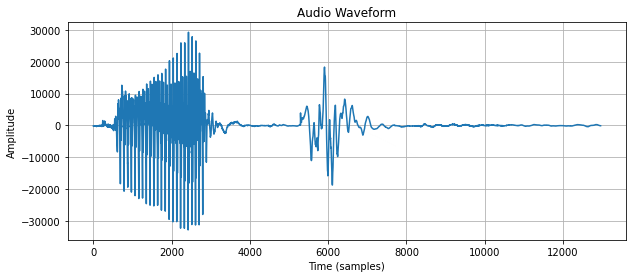

tf.Tensor([[-3.867083  -3.40375    3.107829  -4.9734626  1.9736454 14.452693 ]], shape=(1, 6), dtype=float32)
Confidence:  0.9999844
[5]
Predicted label:  up
Received audio segment with command: 23040


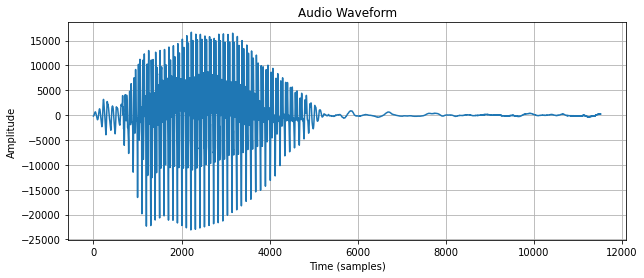

tf.Tensor([[ 1.6448919  5.5161214 -2.5037403 -2.086397  -2.6053517 -2.6088984]], shape=(1, 6), dtype=float32)
Confidence:  0.9782305
[1]
Predicted label:  go
Received audio segment with command: 24960


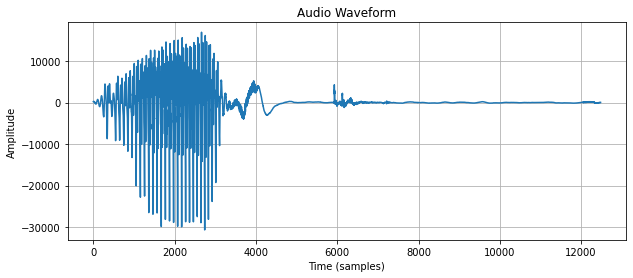

tf.Tensor([[-2.143357  -2.043355   7.426926  -1.3719559 -1.9463105  3.0387113]], shape=(1, 6), dtype=float32)
Confidence:  0.9873563
[2]
Predicted label:  left
Received audio segment with command: 24000


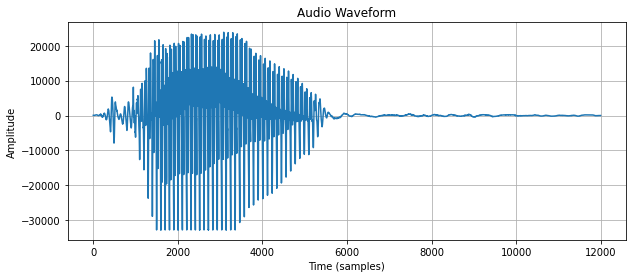

tf.Tensor([[ 2.4052727  9.416878  -3.5497525 -3.4151945 -4.078449  -4.472292 ]], shape=(1, 6), dtype=float32)
Confidence:  0.9990922
[1]
Predicted label:  go
Received audio segment with command: 26880


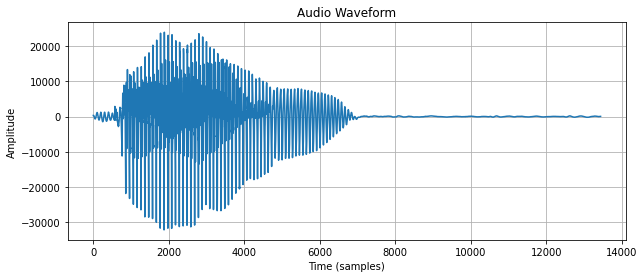

tf.Tensor([[ 8.636942   3.5253472 -5.181852  -0.6132598 -5.552021  -7.0393925]], shape=(1, 6), dtype=float32)
Confidence:  0.9939129
[0]
Predicted label:  down
Received audio segment with command: 24960


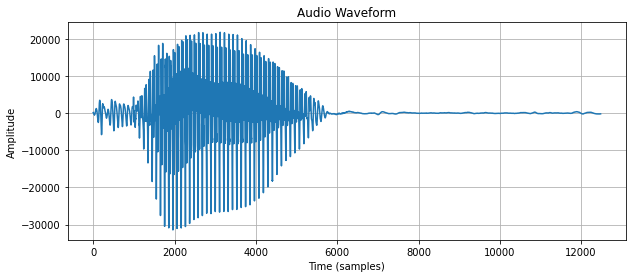

tf.Tensor([[ 2.1772232  7.9936423 -3.262161  -3.1710794 -3.3116663 -4.233526 ]], shape=(1, 6), dtype=float32)
Confidence:  0.99698657
[1]
Predicted label:  go
Received audio segment with command: 25920


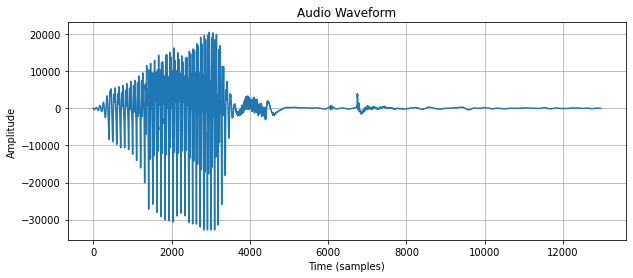

tf.Tensor([[-1.7254386  -1.2731482   5.2723265   0.09977441 -1.7082123   0.12634444]], shape=(1, 6), dtype=float32)
Confidence:  0.9854419
[2]
Predicted label:  left
Received audio segment with command: 24960


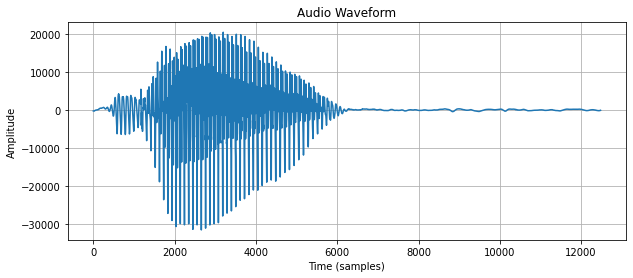

tf.Tensor([[ 2.0775526  5.7041664 -1.7290763 -2.4363174 -2.7142978 -3.894309 ]], shape=(1, 6), dtype=float32)
Confidence:  0.9729733
[1]
Predicted label:  go
Received audio segment with command: 29760


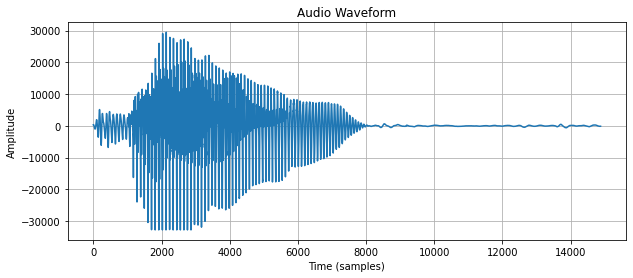

tf.Tensor([[ 12.20357     6.4797635  -7.980542   -3.3866992  -5.7611732 -11.133771 ]], shape=(1, 6), dtype=float32)
Confidence:  0.99674326
[0]
Predicted label:  down
Received audio segment with command: 25920


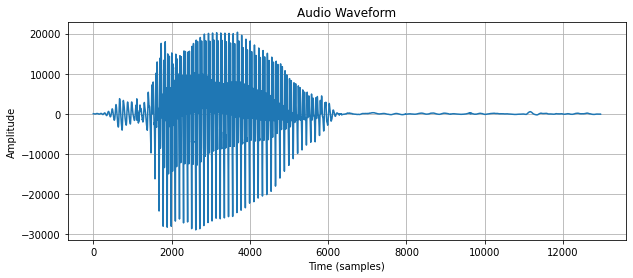

tf.Tensor([[ 2.1373374  7.257738  -3.4594374 -2.8201509 -2.9602091 -3.6319604]], shape=(1, 6), dtype=float32)
Confidence:  0.993944
[1]
Predicted label:  go
Received audio segment with command: 35520


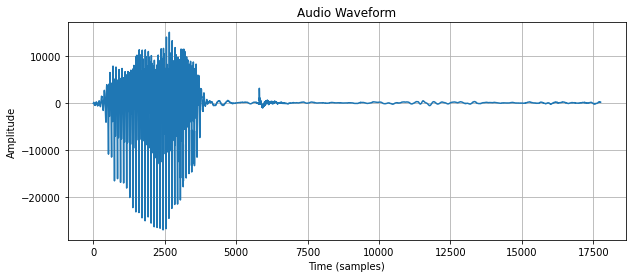

tf.Tensor([[-1.3185818   0.67644864 -0.04841277 13.159553   -6.264606   -4.7862415 ]], shape=(1, 6), dtype=float32)
Confidence:  0.9999938
[3]
Predicted label:  right
Received audio segment with command: 24000


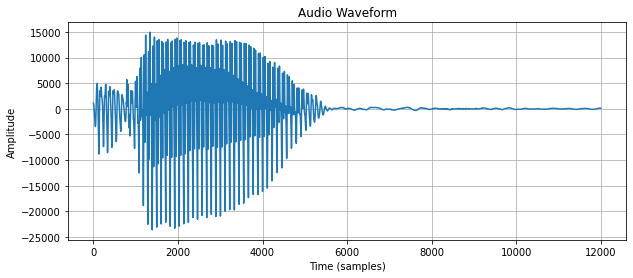

tf.Tensor([[ 0.8950272  3.9513693 -1.6194302 -1.8006531 -1.219201  -1.7422556]], shape=(1, 6), dtype=float32)
Confidence:  0.9406525
[1]
Predicted label:  go
Received audio segment with command: 27840


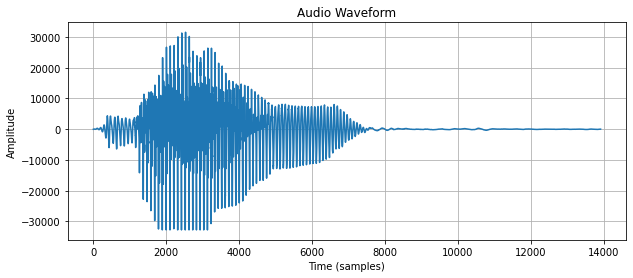

tf.Tensor([[11.233864   4.911442  -6.9921465 -2.4768224 -5.039792  -9.988671 ]], shape=(1, 6), dtype=float32)
Confidence:  0.9982064
[0]
Predicted label:  down
Received audio segment with command: 24960


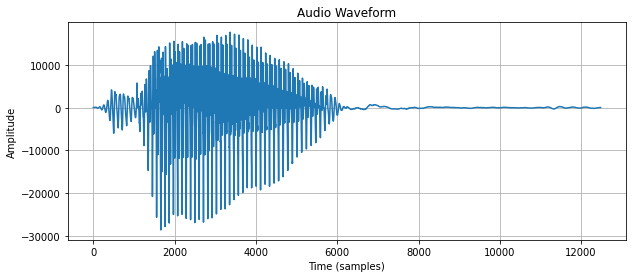

tf.Tensor([[ 2.0025883  5.3908587 -2.5276604 -2.139084  -1.9722102 -3.6973877]], shape=(1, 6), dtype=float32)
Confidence:  0.9657963
[1]
Predicted label:  go
Received audio segment with command: 29760


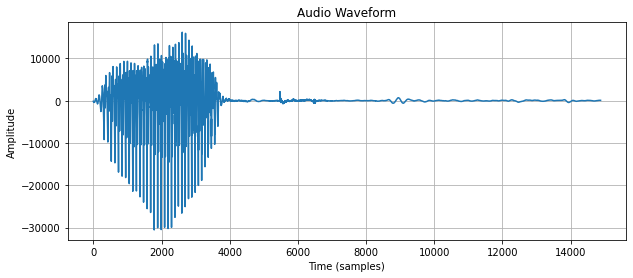

tf.Tensor([[-1.6983624   1.0594516   0.36774904 14.492602   -6.772418   -5.781498  ]], shape=(1, 6), dtype=float32)
Confidence:  0.99999774
[3]
Predicted label:  right
Received audio segment with command: 24960


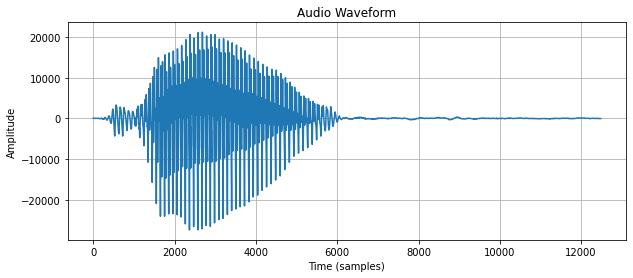

tf.Tensor([[ 2.0928416  6.060971  -2.4468367 -2.4315681 -2.3292937 -3.8035257]], shape=(1, 6), dtype=float32)
Confidence:  0.9807818
[1]
Predicted label:  go
Received audio segment with command: 25920


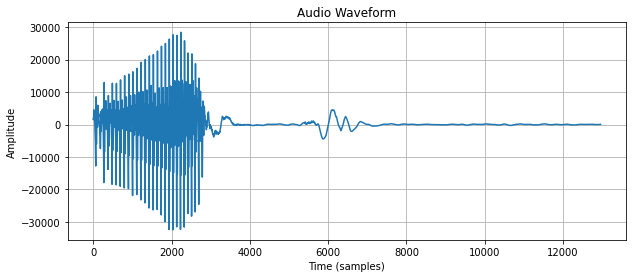

tf.Tensor([[-2.579502  -2.2479358  1.7605942 -4.1260614  1.6884996 10.735339 ]], shape=(1, 6), dtype=float32)
Confidence:  0.9997515
[5]
Predicted label:  up
Received audio segment with command: 33600


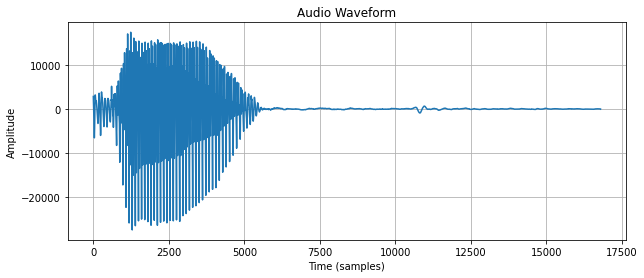

tf.Tensor([[ 1.4992021  5.5919614 -2.367224  -2.5041857 -2.010388  -2.6460497]], shape=(1, 6), dtype=float32)
Confidence:  0.9822112
[1]
Predicted label:  go
Received audio segment with command: 24000


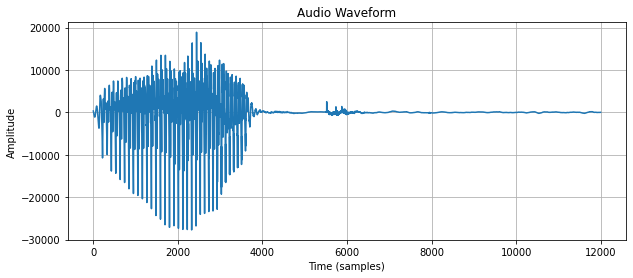

tf.Tensor([[-1.4894539   1.0258429  -0.24422891 17.195795   -8.201055   -5.7816463 ]], shape=(1, 6), dtype=float32)
Confidence:  0.9999999
[3]
Predicted label:  right
Received audio segment with command: 27840


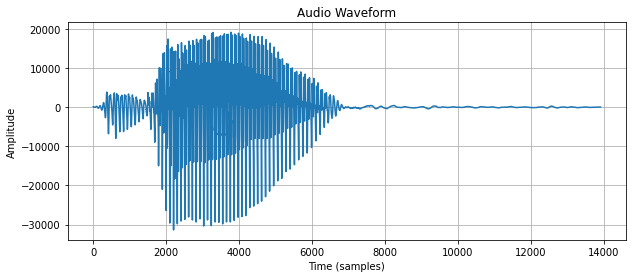

tf.Tensor([[ 2.3502438  7.5415053 -3.4560049 -3.5264761 -2.4241917 -4.2499804]], shape=(1, 6), dtype=float32)
Confidence:  0.99437994
[1]
Predicted label:  go
Received audio segment with command: 36480


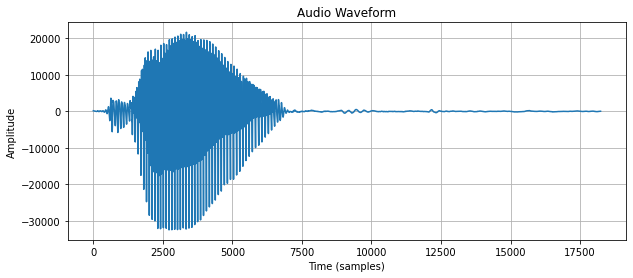

tf.Tensor([[ 2.5030863  8.2490835 -3.2851634 -3.9169497 -2.929786  -4.9341016]], shape=(1, 6), dtype=float32)
Confidence:  0.996784
[1]
Predicted label:  go
Received audio segment with command: 32640


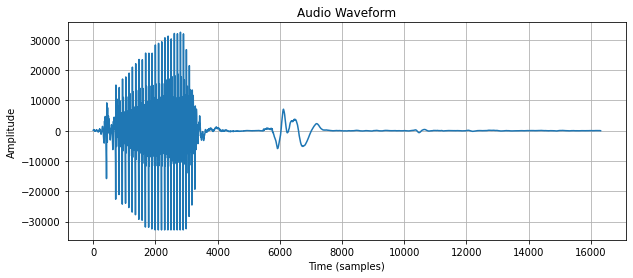

tf.Tensor([[-3.7868595 -3.9582872  1.4701298 -7.0754557  2.8031297 17.064781 ]], shape=(1, 6), dtype=float32)
Confidence:  0.99999917
[5]
Predicted label:  up
Received audio segment with command: 24960


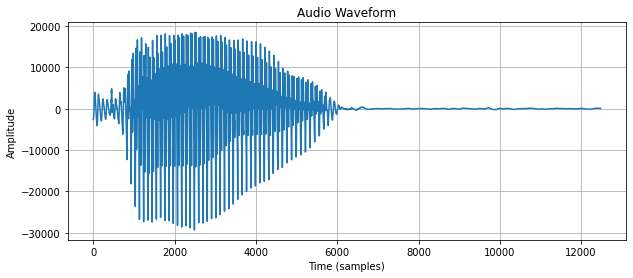

tf.Tensor([[ 1.4224014  5.3201227 -2.0464828 -2.7459624 -1.5550486 -2.7712588]], shape=(1, 6), dtype=float32)
Confidence:  0.97792494
[1]
Predicted label:  go
Received audio segment with command: 37440


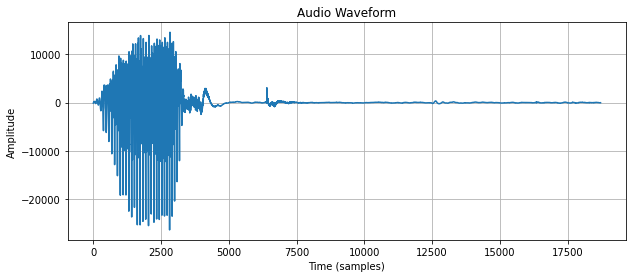

tf.Tensor([[-1.7781599  -2.169011    6.8700733  -0.74048394 -1.5185041   2.0038517 ]], shape=(1, 6), dtype=float32)
Confidence:  0.99135613
[2]
Predicted label:  left
Received audio segment with command: 26880


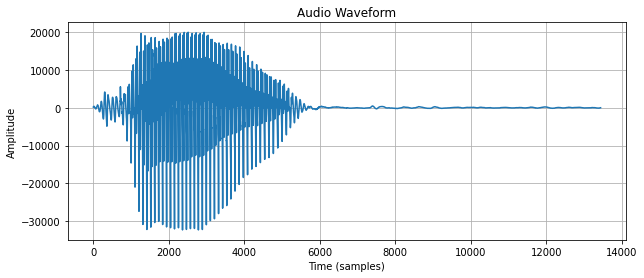

tf.Tensor([[ 1.871048   6.227756  -2.2753303 -3.1543555 -2.1261055 -3.6604369]], shape=(1, 6), dtype=float32)
Confidence:  0.98678327
[1]
Predicted label:  go
Received audio segment with command: 24960


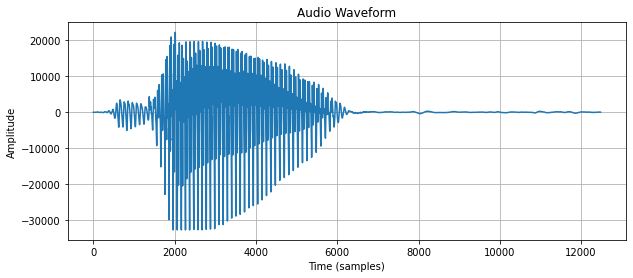

tf.Tensor([[ 2.1868346  6.5171328 -2.9424512 -3.3052125 -1.2361629 -4.038117 ]], shape=(1, 6), dtype=float32)
Confidence:  0.98643523
[1]
Predicted label:  go
Received audio segment with command: 28800


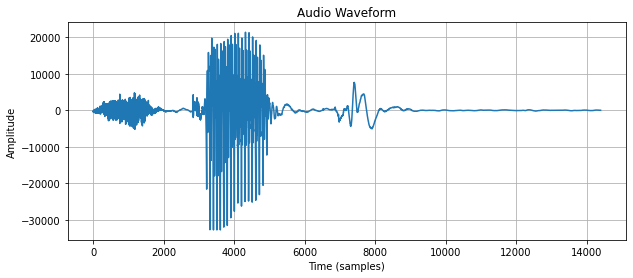

tf.Tensor([[-1.4808565  1.5928298 -1.6875498 -1.7386287  2.1942728  2.7488992]], shape=(1, 6), dtype=float32)
Confidence:  0.5190357
Недостаточно уверенное предсказание. Пропускаем.
[5]
Predicted label:  up
Received audio segment with command: 40320


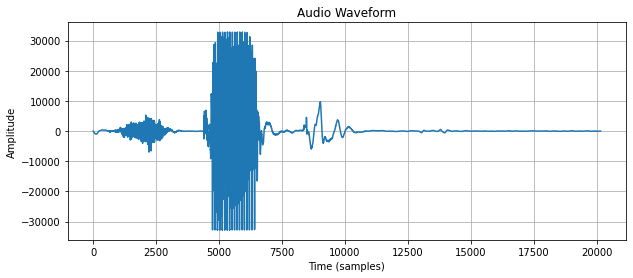

tf.Tensor([[-3.0424967  -1.9858748  -6.7372413  -7.0207076  14.505099   -0.80868155]], shape=(1, 6), dtype=float32)
Confidence:  0.99999976
[4]
Predicted label:  stop
Stopping the turtle


In [6]:
s = turtle.getscreen()

t = turtle.Turtle() # starts at right:

size = t.turtlesize()
increase = (2 * num for num in size)
t.turtlesize(*increase)

t.pensize(5)
t.shapesize()
t.pencolor("blue")

def go_right():
    # target = 0
    current = t.heading()
    if current == 0:
        pass
    elif current == 90:
        t.right(90)
    elif current == 180:
        t.right(180)
    elif current == 270:
        t.left(90)
    else:
        raise ValueError('not a right angle!')

def go_up():
    # target = 90
    current = t.heading()
    if current == 0:
        t.left(90)
    elif current == 90:
        pass
    elif current == 180:
        t.right(90)
    elif current == 270:
        t.left(180)
    else:
        raise ValueError('not a right angle!')
    
def go_left():
    # target = 180
    current = t.heading()
    if current == 0:
        t.left(180)
    elif current == 90:
        t.left(90)
    elif current == 180:
        pass
    elif current == 270:
        t.right(90)
    else:
        raise ValueError('not a right angle!')
    
def go_down():
    # target = 270
    current = t.heading()
    if current == 0:
        t.right(90)
    elif current == 90:
        t.right(180)
    elif current == 180:
        t.left(90)
    elif current == 270:
        pass
    else:
        raise ValueError('not a right angle!')


def move_turtle(command):
    if command == 'up':
        go_up()
    elif command == 'down':
        go_down()
    elif command == 'left':
        go_left()
    elif command == 'right':
        go_right()
    elif command == 'go':
        t.forward(100)
    elif command == 'stop':
        s.bye()
        print('Stopping the turtle')


# Создание экземпляра VAD
vad = webrtcvad.Vad(3)  # Уровень агрессивности VAD (1-3)

# Получение отрезков с командами
audio_generator = record_audio()
for audio_segment in vad_collector(RATE, FRAME_DURATION_MS, PADDING_DURATION_MS, vad, audio_generator):
    print("Received audio segment with command:", len(audio_segment))
    waveform = np.frombuffer(audio_segment, dtype=np.int16)
    plot_waveform(waveform)
    spec = preprocess_audiobuffer(waveform)
    prediction = model(spec)
    print(prediction)
    confidence = np.max(tf.nn.softmax(prediction))
    print('Confidence: ', confidence)
    if confidence < 0.7:
        print("Недостаточно уверенное предсказание. Пропускаем.")
        label_pred = np.argmax(prediction, axis=1)
        print(label_pred)
        command = commands[label_pred[0]]
        print('Predicted label: ', command)
    else:
        label_pred = np.argmax(prediction, axis=1)
        print(label_pred)
        command = commands[label_pred[0]]
        print('Predicted label: ', command)
        move_turtle(command)
        if command == "stop":
            break

